## 5.1. Creating Seq2Seq Training Model for Language Translation

In [ ]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
LSTM_NODES =512
TOTAL_SENTENCES = 20000
MAX_SEN_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
input_english_sentences = []
output_french_sentences = []
output_french_sentences_inputs = []

count = 0
for line in open(r'/gdrive/My Drive/datasets/fra.txt', encoding="utf-8"):
    count += 1

    if count > TOTAL_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence = line.rstrip().split('\t')[0]
    
    output = line.rstrip().split('\t')[1]
    
    
    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_english_sentences.append(input_sentence)
    output_french_sentences.append(output_sentence)
    output_french_sentences_inputs.append(output_sentence_input)


In [ ]:
print("num samples input:", len(input_english_sentences))
print("num samples output:", len(output_french_sentences))
print("num samples output input:", len(output_french_sentences_inputs))

num samples input: 20000
num samples output: 20000
num samples output input: 20000


In [ ]:
print(input_english_sentences[175])
print(output_french_sentences[175])
print(output_french_sentences_inputs[175])

I'm shy.
Je suis timide. <eos>
<sos> Je suis timide.


In [ ]:
input_eng_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_eng_tokenizer.fit_on_texts(input_english_sentences)
input_eng_integer_seq = input_eng_tokenizer.texts_to_sequences(input_english_sentences)

word2idx_eng_inputs = input_eng_tokenizer.word_index
print('Sum of unique words in English sentences: %s' % len(word2idx_eng_inputs))

max_input_len = max(len(sen) for sen in input_eng_integer_seq)
print("Length of longest sentence in English sentences: %g" % max_input_len)

Sum of unique words in English sentences: 3514
Length of longest sentence in English sentences: 6


In [ ]:
output_french_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_french_tokenizer.fit_on_texts(output_french_sentences + output_french_sentences_inputs)
output_french_integer_seq = output_french_tokenizer.texts_to_sequences(output_french_sentences)
output_input_french_integer_seq = output_french_tokenizer.texts_to_sequences(output_french_sentences_inputs)

word2idx_french_outputs = output_french_tokenizer.word_index
print('Sum of unique words in French sentences: %s' % len(word2idx_french_outputs))

num_words_output = len(word2idx_french_outputs) + 1
max_out_len = max(len(sen) for sen in output_french_integer_seq)
print("Length of longest sentence in French sentences: %g" % max_out_len)


Sum of unique words in French sentences: 9532
Length of longest sentence in French sentences: 13


In [ ]:
encoder_input_eng_sequences = pad_sequences(input_eng_integer_seq, maxlen=max_input_len)
print("encoder_input_eng_sequences.shape:", encoder_input_eng_sequences.shape)
print("encoder_input_eng_sequences[175]:", encoder_input_eng_sequences[175])

print(word2idx_eng_inputs["i'm"])
print(word2idx_eng_inputs["shy"])

encoder_input_eng_sequences.shape: (20000, 6)
encoder_input_eng_sequences[175]: [  0   0   0   0   6 307]
6
307


In [ ]:
decoder_input_french_sequences = pad_sequences(output_input_french_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_french_sequences.shape:", decoder_input_french_sequences.shape)
print("decoder_input_french_sequences[175]:", decoder_input_french_sequences[175])

print(word2idx_french_outputs["<sos>"])
print(word2idx_french_outputs["je"])
print(word2idx_french_outputs["suis"])
print(word2idx_french_outputs["timide."])

decoder_input_french_sequences.shape: (20000, 13)
decoder_input_french_sequences[175]: [  2   3   6 339   0   0   0   0   0   0   0   0   0]
2
3
6
339


In [ ]:
decoder_output_french_sequences = pad_sequences(output_french_integer_seq, maxlen=max_out_len, padding='post')

In [ ]:

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'/gdrive/My Drive/datasets/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
num_words = min(MAX_NUM_WORDS, len(word2idx_eng_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_eng_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [ ]:
decoder_one_hot_targets = np.zeros((
        len(input_english_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [ ]:
decoder_one_hot_targets.shape

(20000, 13, 9533)

In [ ]:
for i, d in enumerate(decoder_output_french_sequences):
    for t, word in enumerate(d):
        decoder_one_hot_targets[i, t, word] = 1
        

In [ ]:
encoder_inputs_eng_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_eng_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]


In [ ]:
decoder_inputs_french_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_french_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

###

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs_eng_placeholder,
  decoder_inputs_french_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

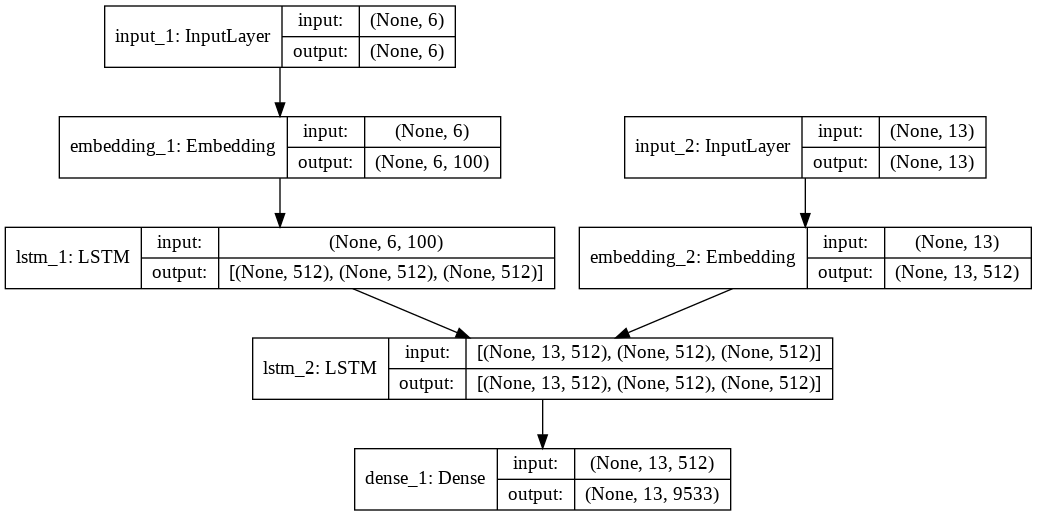

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
r = model.fit(
    [encoder_input_eng_sequences, decoder_input_french_sequences],
    decoder_one_hot_targets,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=0.1,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 18000 samples, validate on 2000 samples
Epoch 1/20
18000/18000 [==============================] - 25s 1ms/step - loss: 1.8342 - accuracy: 0.7395 - val_loss: 1.8702 - val_accuracy: 0.7342
Epoch 2/20
18000/18000 [==============================] - 23s 1ms/step - loss: 1.3023 - accuracy: 0.8049 - val_loss: 1.6485 - val_accuracy: 0.7558
Epoch 3/20
18000/18000 [==============================] - 23s 1ms/step - loss: 1.1163 - accuracy: 0.8278 - val_loss: 1.5532 - val_accuracy: 0.7734
Epoch 4/20
18000/18000 [==============================] - 23s 1ms/step - loss: 0.9931 - accuracy: 0.8426 - val_loss: 1.4753 - val_accuracy: 0.7832
Epoch 5/20
18000/18000 [==============================] - 23s 1ms/step - loss: 0.8994 - accuracy: 0.8541 - val_loss: 1.4386 - val_accuracy: 0.7890
Epoch 6/20
18000/18000 [==============================] - 23s 1ms/step - loss: 0.8226 - accuracy: 0.8645 - val_loss: 1.4668 - val_accuracy: 0.7827
Epoch 7/20
18000/18000 [==============================] - 23s 1ms/ste

## 5.2. Making Predictions using Seq2Seq

In [ ]:
encoder_prediction_model = Model(encoder_inputs_eng_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)


decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)



decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)


decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)


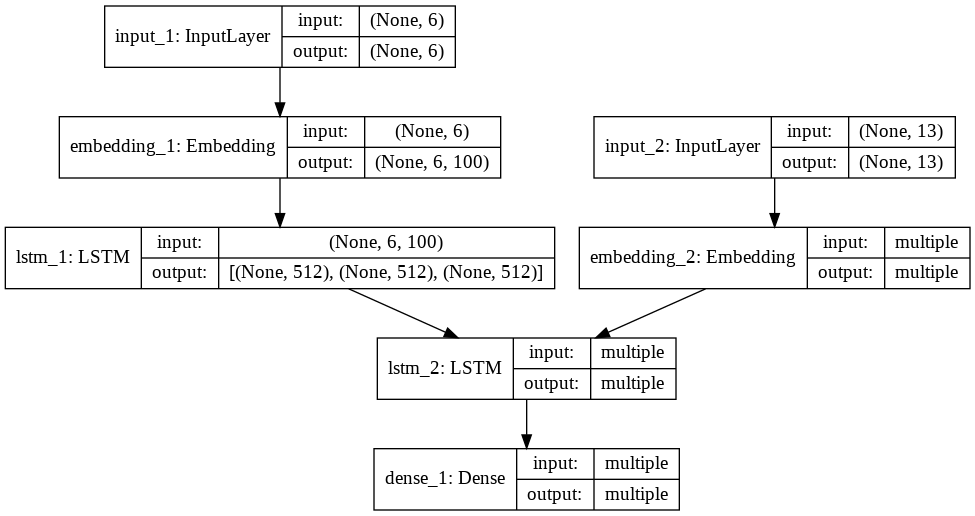

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
idx2word_eng_input = {v:k for k, v in word2idx_eng_inputs.items()}
idx2word_french_target = {v:k for k, v in word2idx_french_outputs.items()}

In [ ]:
def perform_translation(input_seq):
    states_value = encoder_prediction_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_french_outputs['<sos>']
    eos = word2idx_french_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_french_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [ ]:
random_sentence_index = np.random.choice(len(input_english_sentences))
input_eng_seq = encoder_input_eng_sequences[random_sentence_index:random_sentence_index+1]
translation = perform_translation(input_eng_seq)
print('-')
print('Input Sentence:', input_english_sentences[random_sentence_index])
print('Translated Sentence:', translation)

-
Input Sentence: You need sleep.
Translated Sentence: vous avez besoin de sommeil.


## Exercise 5.1

**Question 1:**

This process where ground truth value of the previous output is fed as input to the next timestep, is called teacher forcing

A.	Truth Labelling

B.	Input Labelling

C.	Input Forcing

D.	Teacher Forcing

**Answer: D**

**Question 2:**

In seq2seq model, the input to the node in the decoder layer is.

A.	Hidden State from the encoder

B.	Cell state from the encoder

C.	A "start of sentence" tag

D.	All of the above

**Answer: D**

**Question 3:**

To end predictions using decoder LSTM in seq2seq, what strategy is adopted?

A.	End sentence if maximum sentence length is achieved

B.	End sentence if "end of sentence" tag is predicted

C.	Both A and B

D.	None of the Above

**Answer: C**
